# Surface properties 

## 6 hourly

In [51]:
import numpy as np 
import xarray as xr 
import glob 
import wrf 
import matplotlib.pyplot as plt
import atmotrans
from atmotrans import R
from scipy import interpolate

# surface pressures 6 hourly 
sp_files= glob.glob('../moisture_transport/moisture_transport/tmpdir/6hourly_test/surface*')
sp_files.sort()
# primes for 6 hours 
prim_files = glob.glob('../moisture_transport/moisture_transport/tmpdir/6hourly_test/*prime*')
prim_files.sort()

In [9]:
surface_properties = 

# get data 
pressure = xr.open_dataset(prim_files[idx])
q = pressure.q[0]
sfrc = xr.open_dataset(sp_files[idx])
sp= sfrc.sp[0].values/ 100
u10 = sfrc.u10[0]
v10 = sfrc.v10[0]
levels = np.zeros(q.shape)

for ilat in np.arange(q.shape[1]):
    for ilon in np.arange(q.shape[2]):
        levels[:, ilat, ilon ]= pressure.level.values
        sp_value = sp[ilat,ilon]
        if sp_value < 1000:
            # function for extrapolation/ interpolation: 
            x_vals = pressure.level.values
            y_vals= q[:,ilat,ilon]
            f = interpolate.interp1d(x_vals, y_vals, fill_value = "extrapolate", kind = 'cubic')
            q[36, ilat, ilon] = f(sp_value)
            
# get humidity value for surface pressures 
surface_humidity = wrf.interplevel(q, levels, sp)

# merge both 
surface_humidity.values[np.isnan(surface_humidity.values)] = 0 
surface_q= q[36].values
surface_q[surface_humidity > 0 ] = 0 
humidity = surface_humidity + surface_q

# get gradient for surface pressure 
dlat,dlon = atmotrans.get_spacing(pressure.latitude.values, pressure.longitude.values)
ps_x = atmotrans.derivative_u(sp, dlon)
ps_y = atmotrans.derivative_v(sp, dlat)

# product 
surface_properties += humidity[1:,1:] * (u10[1:,1:] * ps_x + v10[1:,1:] * ps_y)

In [42]:
# conversion of specific humidity in mm/d
p_d = (sp * 100)/(R*T)
humidity *= p_d * 86400 

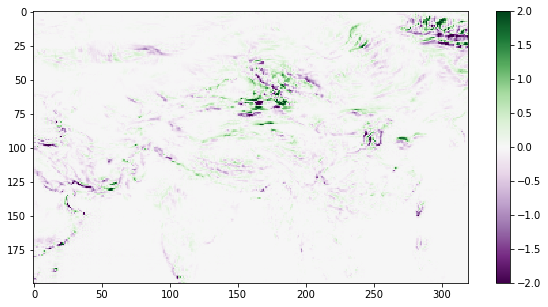

In [50]:
plt.figure(figsize= (10,5))

plt.imshow(- surface_properties, vmin = -8, vmax = 8,cmap = 'PRGn')
plt.colorbar()